In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
from random import randint
import re, math
import seaborn as sns; sns.set_style("white")
from sklearn.manifold import TSNE
import umap.umap_ as umap
import datetime
import gc
from pathlib import Path
from cytominer_eval import evaluate
import plotly.graph_objects as go
#import plotly.offline as pyo
#import plotly.io as pio
os.getcwd()

'/home/jovyan/maris/2022/24OHC'

In [2]:
figformat = 'png'
dpi = 150
project = '24OHC'

In [3]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)


    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Read data

In [4]:
BaseDir = './ImageMeanFeatures/'
sorted(os.listdir(BaseDir))

['.ipynb_checkpoints',
 'ImageMeansAllPlates.csv',
 'ImageMeansAllPlates_2.csv',
 'ImageMeansPlate24OHC-v1-FA-00000468-T98G-24h-P1-L1.csv',
 'ImageMeansPlate24OHC-v1-FA-00000475-T98G-24h-P1-L2.csv']

### Output directory

In [5]:
OutputDir = input("Enter name for output folder: ") #
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)

Enter name for output folder:  PCA_Umap_Tsne


In [6]:
df = pd.read_csv('{}/ImageMeansAllPlates_2.csv'.format(BaseDir), sep=';' , index_col=0)
df.shape

(5353, 2126)

In [7]:
df['plate'] = df.index.str[-11:-6] 
df['plate-name'] = df.index.str[:12] + 'plate' + df.index.str[-10:-6] + '-' + df.index.str[16:24]
df['well_id'] = df.index.str[-5:-2]
df['L'] = df['plate'].str[-2:]
df['plateWell'] = df['L'] + '_' + df['well_id']
df['site'] = df.index.str[-1:]


In [8]:
df.tail(1)

,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,plate,plate-name,well_id,L,plateWell,site
ImageID,,,,,,,,,,,,,,,,,,,,,
24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_9,1,126.0,9,1312.043825,1912.513944,1009.569721,1189.633466,968.119522,1147.087649,988.321742,...,-0.037985,-0.441973,0.131609,0.182228,P1-L2,24OHC-v1-FA-plate1-L2-0475-T98,O23,L2,L2_O23,9


In [9]:
Layout =  pd.read_csv('24OHC_layout_conc_L1_L2.csv', sep=';')
Layout.head(1)

,plateID,new_plate_name,well,cbk_id,cpd_conc,cpd_conc_unit,DMSO_conc,DMSO_conc_unit
0,L1,24OHC2-v1-plate1-L1,B03,[berb],10.0,uM,0.1,perc


In [10]:
Layout['plateWell']= Layout['plateID'] + '_' + Layout['well']
Layout.tail(1)

,plateID,new_plate_name,well,cbk_id,cpd_conc,cpd_conc_unit,DMSO_conc,DMSO_conc_unit,plateWell
543,L2,24OHC2-v1-plate1-L2,O22,TGFb,3.0,uM,0.1,perc,L2_O22


In [11]:
compoundDict = dict(zip(Layout.plateWell, Layout.cbk_id))
concentrationDict = dict(zip(Layout.plateWell, Layout.cpd_conc))

In [12]:
labels = ['compound', 'concentration']
for a in labels:
    df[a] = df['plateWell'].map(eval('{}Dict'.format(a)))

In [13]:
df.shape

(5353, 2134)

In [14]:
df.dropna(subset = ['compound'], inplace=True)
df.reset_index(drop=False, inplace=True)
df.tail(3)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,plate,plate-name,well_id,L,plateWell,site,compound,concentration
4705,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_7,1,68.0,7,1333.622222,1997.459259,1084.637037,1328.688889,1042.007407,1285.407407,...,0.235481,-0.175427,P1-L2,24OHC-v1-FA-plate1-L2-0475-T98,O23,L2,L2_O23,7,[buffer],0.1
4706,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_8,1,75.0,8,1312.805369,1913.583893,1038.906040,1130.697987,996.322148,1088.395973,...,-0.509931,-0.177970,P1-L2,24OHC-v1-FA-plate1-L2-0475-T98,O23,L2,L2_O23,8,[buffer],0.1
4707,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_9,1,126.0,9,1312.043825,1912.513944,1009.569721,1189.633466,968.119522,1147.087649,...,0.131609,0.182228,P1-L2,24OHC-v1-FA-plate1-L2-0475-T98,O23,L2,L2_O23,9,[buffer],0.1


In [15]:
CompoundList = sorted(list(set(df['compound'])))
CompoundList[:]

['24OHC',
 'TGFb',
 '[berb]',
 '[buffer]',
 '[ca-0]',
 '[cycl]',
 '[dmso]',
 '[etop]',
 '[fenb]',
 '[flup]',
 '[iono]',
 '[meto]',
 '[repa]',
 '[sorb]',
 '[stau]',
 '[tetr]']

In [16]:
PlateList = sorted(list(set(df['plate'])))
PlateList

['P1-L1', 'P1-L2']

### QC


In [17]:
QC =  pd.read_csv('./QC/5SD/5SD_Flags.csv', sep=';', index_col=[0])
QC['ImageID'] = QC['Metadata_Barcode'] + '_' + QC['Metadata_Well'] + '_'  + QC['Metadata_Site'].astype(str)
QC.head(3)

,Metadata_Barcode,Metadata_Well,Metadata_Site,Count_nuclei,ImageQuality_FocusScore_CONC,ImageQuality_FocusScore_HOECHST,ImageQuality_FocusScore_MITO,ImageQuality_FocusScore_PHAandWGA,ImageQuality_FocusScore_SYTO,Outlier_FocusScore_0.01_inf,OutlierScaled_FocusScore_-5_5,OutlierScaled_MaxIntensity_-5_5,OutlierScaled_MeanIntensity_-5_5,OutlierScaled_PowerLogLogSlope_-5_5,OutlierScaled_StdIntensity_-5_5,Total,ImageID
0,24OHC-v1-FA-00000468-T98G-24h-P1-L1,B02,1,118,0.092792,0.028265,0.042481,0.046140,0.129061,0,0,0,0,0,0,0,24OHC-v1-FA-00000468-T98G-24h-P1-L1_B02_1
1,24OHC-v1-FA-00000468-T98G-24h-P1-L1,B02,2,93,0.071831,0.021229,0.033492,0.032343,0.091823,0,0,0,0,0,0,0,24OHC-v1-FA-00000468-T98G-24h-P1-L1_B02_2
2,24OHC-v1-FA-00000468-T98G-24h-P1-L1,B02,3,99,0.080343,0.025887,0.036612,0.036271,0.107007,0,0,0,0,0,0,0,24OHC-v1-FA-00000468-T98G-24h-P1-L1_B02_3


In [18]:
df = df.merge(QC, left_on = 'ImageID', right_on = 'ImageID', how = 'left')

df = df[df['Total'] == 0 ] 
df.shape

(4423, 2151)

In [19]:
df.reset_index(drop=True, inplace=True)
df['WellID'] =df['ImageID'].str[:-1]
df.tail(2)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,ImageQuality_FocusScore_PHAandWGA,ImageQuality_FocusScore_SYTO,Outlier_FocusScore_0.01_inf,OutlierScaled_FocusScore_-5_5,OutlierScaled_MaxIntensity_-5_5,OutlierScaled_MeanIntensity_-5_5,OutlierScaled_PowerLogLogSlope_-5_5,OutlierScaled_StdIntensity_-5_5,Total,WellID
4421,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_8,1,75.0,8,1312.805369,1913.583893,1038.906040,1130.697987,996.322148,1088.395973,...,0.025852,0.062289,0,0,0,0,0,0,0,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_
4422,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_9,1,126.0,9,1312.043825,1912.513944,1009.569721,1189.633466,968.119522,1147.087649,...,0.036038,0.078283,0,0,0,0,0,0,0,24OHC-v1-FA-00000475-T98G-24h-P1-L2_O23_


In [20]:
df['comp_conc'] = df['compound'] + '_' + df['concentration'].astype(str)
df['comp_conc_replicate'] = df['comp_conc'] + '_' + df['plateWell'] + '_' + df['site'].astype(str)

In [21]:
CompoundList


['24OHC',
 'TGFb',
 '[berb]',
 '[buffer]',
 '[ca-0]',
 '[cycl]',
 '[dmso]',
 '[etop]',
 '[fenb]',
 '[flup]',
 '[iono]',
 '[meto]',
 '[repa]',
 '[sorb]',
 '[stau]',
 '[tetr]']

In [22]:
numeric_columns = list()
for a in df.columns:
    if (df.dtypes[a] == 'float64') | (df.dtypes[a] == 'int64') :
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

Found 2141 numeric columns


In [23]:
feature_columns = [fc for fc in numeric_columns if ('Metadata' not in fc) & ('Number' not in fc) &
                   ('Outlier' not in fc)  & ('ImageQuality' not in fc)  & ('concentration' not in fc)  & ('Total' not in fc)]
print('Excluded columns that are "Metadata", etc.: {}'.format(len(feature_columns)))
X = df.loc[:, feature_columns]
X.dropna(axis=1, inplace=True)
print('Removed features with missing values: {}'.format(X.shape[1]))
X = X.loc[:, (X.std() > 0.0001) ]
print('Excluded features with SD < 0.0001 : {}'.format(X.shape[1]))

varying_features = list(X.columns)
#X['ImageID'] = df['ImageID']
#X.tail(1)

Excluded columns that are "Metadata", etc.: 2106
Removed features with missing values: 2106
Excluded features with SD < 0.0001 : 1994


In [24]:
dfDMSO = df[df['compound'] == '[dmso]']  # Calculate median values for DMSO
dfDMSO_Medians = dfDMSO[varying_features].median()

In [25]:
dfDMSO_MADs = (dfDMSO[varying_features] - dfDMSO[varying_features].median()).abs().median() # Calculate median absolute deviations for DMSO

In [26]:
print(len(varying_features))
varying_in_DMSO = dfDMSO_MADs.loc[dfDMSO_MADs > 0.0001].index # Remove features that are invariant or close to invariant in DMSO
len(varying_in_DMSO)

1994


1833

In [27]:
dfZscores = df[varying_in_DMSO].copy()  # Calculate z-scores
dfZscores = (df[varying_in_DMSO] - dfDMSO_Medians[varying_in_DMSO])/dfDMSO_MADs[varying_in_DMSO]
dfZscores.clip(lower=-10, upper=10,  inplace=True) # Clip extreme values

dfZscores = dfZscores.merge(df[['compound', 'concentration', 'plate', 'well_id', 'site', 'comp_conc',
       'comp_conc_replicate' ]], left_index=True, right_index=True) 
dfZscores.tail(5)

,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Count_nuclei,compound,concentration,plate,well_id,site,comp_conc,comp_conc_replicate
4418,0.539544,0.588575,-0.809924,-1.124536,-0.821150,-1.138296,-0.813471,-1.127028,1.325264,0.523290,...,-2.787216,-0.055190,-2.666667,[buffer],0.1,P1-L2,O23,5,[buffer]_0.1,[buffer]_0.1_L2_O23_5
4419,-0.896025,-0.540374,1.449454,1.179088,1.473484,1.186674,1.458428,1.181260,0.031054,-0.827047,...,-0.627196,-0.824280,1.444444,[buffer],0.1,P1-L2,O23,6,[buffer]_0.1,[buffer]_0.1_L2_O23_6
4420,0.276915,0.677288,0.021375,3.169090,0.013692,3.157856,0.017805,3.155506,2.024720,0.414592,...,1.391579,-1.000286,-0.333333,[buffer],0.1,P1-L2,O23,7,[buffer]_0.1,[buffer]_0.1_L2_O23_7
4421,-0.059177,-0.216675,-0.585552,0.503770,-0.603484,0.500994,-0.590180,0.504270,-0.523102,-0.179526,...,-2.944621,-1.014647,-0.833333,[buffer],0.1,P1-L2,O23,8,[buffer]_0.1,[buffer]_0.1_L2_O23_8
4422,-0.071472,-0.228079,-0.974895,1.297150,-0.984482,1.292500,-0.978198,1.293111,-1.760328,-0.168700,...,0.787334,1.019105,3.388889,[buffer],0.1,P1-L2,O23,9,[buffer]_0.1,[buffer]_0.1_L2_O23_9


In [28]:
dfZscores.columns[-10:]

Index(['RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm',
       'Count_nuclei', 'compound', 'concentration', 'plate', 'well_id', 'site',
       'comp_conc', 'comp_conc_replicate'],
      dtype='object')

### PCA

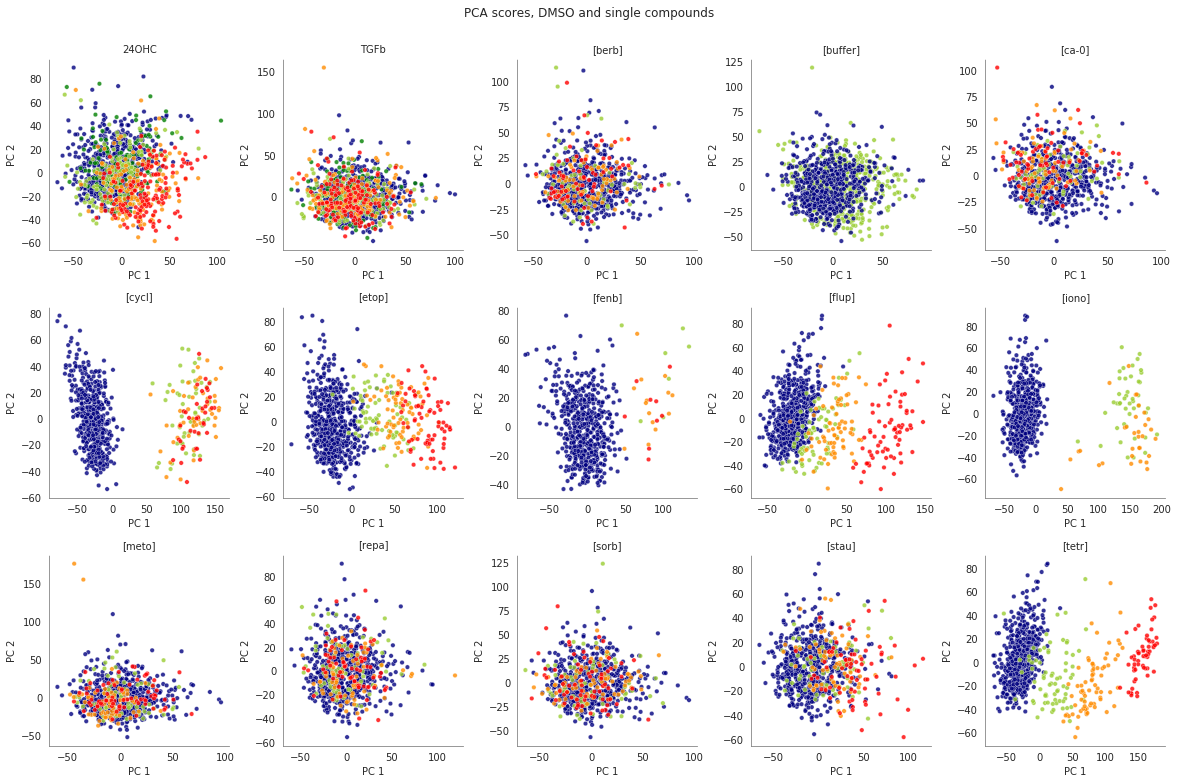

In [29]:
fig = plt.figure(figsize = (20,12))
sp = 1
for comp in (CompoundList[0:6] + CompoundList[7:]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[dfZscores['compound'] == comp]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))
        
        nr_colors = len(set(dfOneCompoundandDMSO['comp_conc']))
        if nr_colors == 4:
            colors = ['navy', 'yellowgreen', 'darkorange', 'red']
        if nr_colors == 5:
            colors = ['navy', 'green','yellowgreen', 'darkorange', 'red'] 
        if nr_colors == 3:
            colors = ['navy', 'yellowgreen', 'darkorange']
        if nr_colors == 2:
            colors = [ 'yellowgreen', 'navy']        
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        pca = PCA(n_components=50)
        #x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        principalDf.sort_values(by = [ 'concentration', 'compound'], inplace = True)
        # principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        ax = fig.add_subplot(3, 5, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        x
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='comp_conc', data=principalDf, palette=colors,  s=20, alpha = 0.8,  marker = 'o');
        ax.set_title('{}'.format(comp), fontsize = 10)
        ax.get_legend().remove()

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust(top =0.92, wspace=0.3, hspace=0.3)
fig.suptitle('PCA scores, DMSO and single compounds'.format(comp), fontsize = 12)
fig.savefig('{}/PCA.{}'.format(OutputDir, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA.{}'.format(OutputDir, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

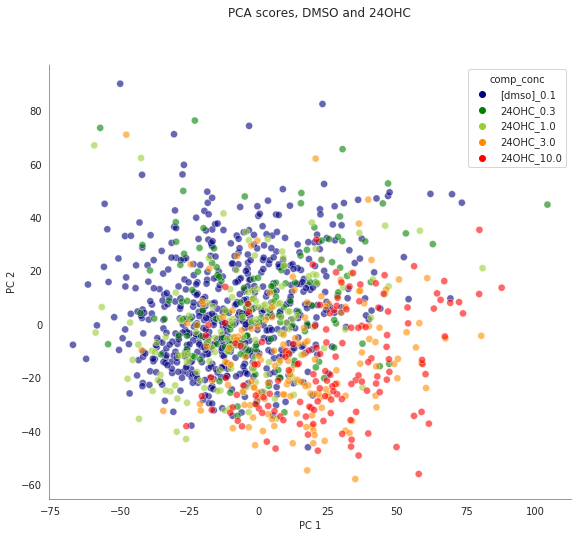

In [30]:
fig = plt.figure(figsize = (10,8))
sp = 1
for comp in (CompoundList[:1]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[dfZscores['compound'] == comp]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))

 
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        pca = PCA(n_components=100)
        #x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        principalDf.sort_values(by = [ 'concentration'], inplace = True)
        principalDf.reset_index(drop=True, inplace = True) 
        principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        ax = fig.add_subplot(1, 1, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='comp_conc', data=principalDf, palette=colors,  s=50, alpha = 0.6,  marker = 'o');
        
        

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust( wspace=0.3, right = 0.85)
fig.suptitle('PCA scores, DMSO and {}'.format(comp), fontsize = 12)
fig.savefig('{}/PCA_DMSOand{}.{}'.format(OutputDir,  comp, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA_DMSOand{}.{}'.format(OutputDir,  comp, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

[0 0 0 ... 1 1 1]
[[-1.00087681]
 [-1.00087681]
 [-1.00087681]
 ...
 [ 0.99912396]
 [ 0.99912396]
 [ 0.99912396]]
[-2.48435387e+31 -2.99576517e+31 -1.89083964e-02 -2.27601053e+31
 -1.97936405e+31]


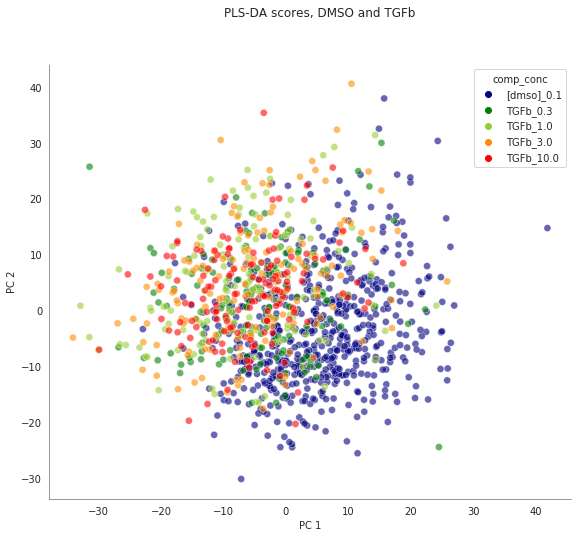

In [81]:
fig = plt.figure(figsize = (10,8))
sp = 1
for comp in (CompoundList[1:2]):
    #for plate in PlateList:
        # fOneCompound = df.loc[(df['compound'] == comp), ['compound','plate' ] + varying_features]
        dfOneCompound = dfZscores.loc[(dfZscores['compound'] == comp) & (dfZscores['concentration'] != 'Placeholder')]
        dfDMSO = dfZscores.loc[dfZscores['compound'] == '[dmso]']
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames)
        #dfOneCompoundandDMSO['plate_comp_conc'] = dfOneCompoundandDMSO['plate'] +'_' + dfOneCompoundandDMSO['compound'] +'_' + dfOneCompoundandDMSO['concentration'].astype(str)
        #dfOneCompoundandDMSO.sort_values(by = ['plate', 'compound', 'concentration'], inplace = True)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        #PlateCompConcList = list(dict.fromkeys(list(dfOneCompoundandDMSO['plate_comp_conc'])))

 
        x = dfOneCompoundandDMSO.loc[:, varying_in_DMSO].values
        dfOneCompoundandDMSO['class'] = np.where(dfOneCompoundandDMSO['compound'] == '[dmso]', 0, 1)
        y = dfOneCompoundandDMSO.loc[:, 'class'].values
        x = StandardScaler(with_mean=True, with_std=False).fit_transform(x)
        #y = dfOneCompoundandDMSO.loc[:, 'concentration'].values
        print(y)
        y = StandardScaler().fit_transform(y.reshape(-1, 1))
        print(y)
        pls2 = PLSRegression(n_components=2)
        pls2.fit(x, y)
        Q2 = cross_val_score(pls2, x, y, cv=5, scoring='r2')
        print(Q2)
        scores = pls2.x_scores_
        scoreDf = pd.DataFrame(data = scores) #, columns = ['comp1', 'comp2', 'comp3'])
        scoreDf.rename(columns={0: 'comp1', 1: 'comp2'}, inplace=True)        
        
        scoreDf = scoreDf.merge(dfOneCompoundandDMSO[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
        scoreDf.sort_values(by = [ 'concentration'], inplace = True)
        scoreDf.reset_index(drop=True, inplace = True) 
        scoreDf.to_csv('{}/PLS_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        
        
        
        ax = fig.add_subplot(1, 1, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
        # colors = ['navy','red']
        ax =sns.scatterplot(x='comp1', y='comp2',  
                          hue='comp_conc', data=scoreDf, palette=colors,  s=50, alpha = 0.6,  marker = 'o');
        
        

        ax.set_facecolor('w')
        sp += 1
plt.subplots_adjust( wspace=0.3, right = 0.85)
fig.suptitle('PLS-DA scores, DMSO and {}'.format(comp), fontsize = 12)
fig.savefig('{}/PLSDA_DMSOand{}.{}'.format(OutputDir,  comp, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PLSDA_DMSOand{}.{}'.format(OutputDir,  comp, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

### Umap

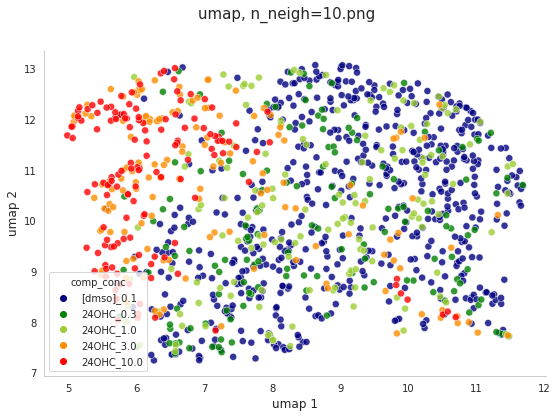

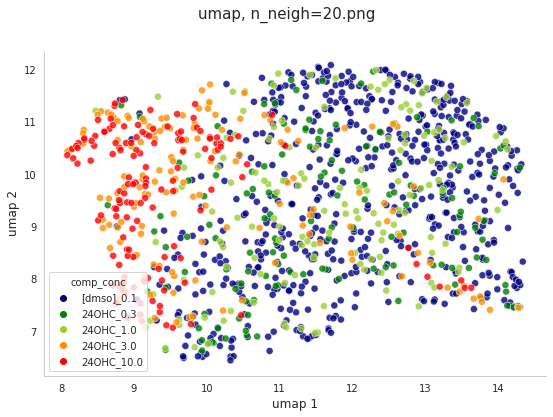

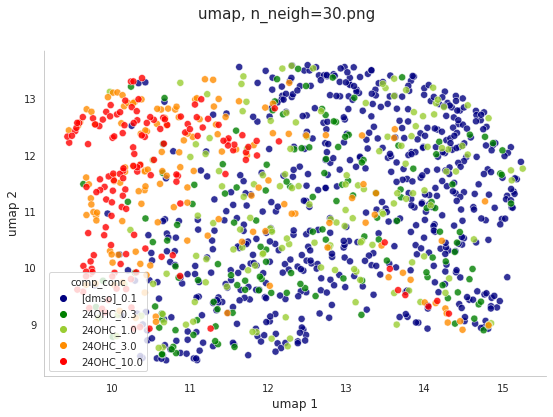

In [31]:
for n_neighbors in range(10, 31, 10):      
            reducer = umap.UMAP(n_neighbors = n_neighbors)
            embedding = reducer.fit_transform(principalDf.iloc[:,:50] )
            umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
            umap_resultDf = pd.concat([umap_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            umap_resultDf.sort_values(by = [ 'concentration'], inplace = True)
            umap_resultDf.to_csv('{}/umap.csv'.format(OutputDir), sep=';')

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('umap 1', fontsize = 12)
            ax.set_ylabel('umap 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')
            colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
            ax =sns.scatterplot(x='umap 1', y='umap 2',  
                          hue='comp_conc', data=umap_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('umap, n_neigh={}.png'.format(n_neighbors), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Umap_DMSOand_{}_nneighb_{}.{}'.format(OutputDir,  comp, n_neighbors, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

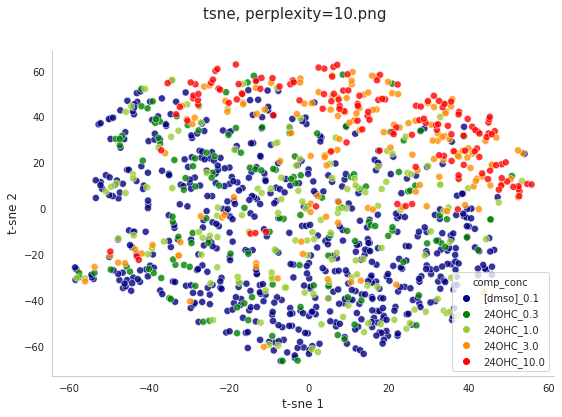

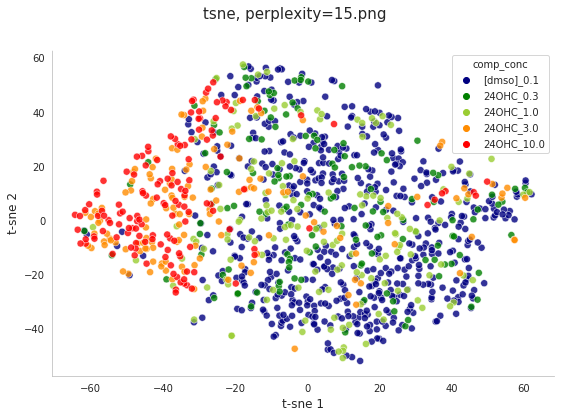

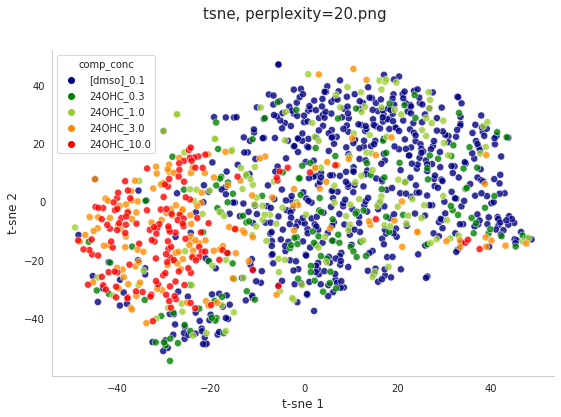

In [32]:
for perpl in range(10, 21, 5):
            x = principalDf.iloc[:, :50].values
            X_embedded = TSNE(n_components=2, perplexity=perpl).fit_transform(x)
            tsne_result = pd.DataFrame(data = X_embedded, columns=["tsne 1", "tsne 2"])
            tsne_resultDf = pd.concat([tsne_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            tsne_resultDf.sort_values(by = [ 'concentration'], inplace = True)
            tsne_resultDf.to_csv('{}/tsne.csv'.format(OutputDir), sep=';')

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('t-sne 1', fontsize = 12)
            ax.set_ylabel('t-sne 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')
            colors = ['navy', 'green', 'yellowgreen', 'darkorange', 'red']
            ax =sns.scatterplot(x='tsne 1', y='tsne 2',  
                          hue='comp_conc', data=tsne_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('tsne, perplexity={}.png'.format(perpl), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Tsne_DMSOand_{}_perpl_{}.{}'.format(OutputDir,  comp, perpl, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

In [33]:
print(sorted(list(set(df.comp_conc))))

['24OHC_0.3', '24OHC_1.0', '24OHC_10.0', '24OHC_3.0', 'TGFb_0.3', 'TGFb_1.0', 'TGFb_10.0', 'TGFb_3.0', '[berb]_10.0', '[berb]_3.0', '[berb]_5.0', '[buffer]_0.1', '[ca-0]_10.0', '[ca-0]_3.0', '[ca-0]_5.0', '[cycl]_10.0', '[cycl]_3.0', '[cycl]_5.0', '[dmso]_0.1', '[etop]_10.0', '[etop]_3.0', '[etop]_5.0', '[fenb]_10.0', '[fenb]_3.0', '[fenb]_5.0', '[flup]_10.0', '[flup]_3.0', '[flup]_5.0', '[iono]_3.0', '[iono]_5.0', '[meto]_10.0', '[meto]_3.0', '[meto]_5.0', '[repa]_10.0', '[repa]_3.0', '[repa]_5.0', '[sorb]_10.0', '[sorb]_3.0', '[sorb]_5.0', '[stau]_10.0', '[stau]_3.0', '[stau]_5.0', '[tetr]_10.0', '[tetr]_3.0', '[tetr]_5.0']


In [51]:
SelectedCompConc = ['24OHC_10.0',  'TGFb_10.0', '[ca-0]_10.0',
                   '[cycl]_3.0', '[dmso]_0.1',  '[etop]_10.0', 
                  '[fenb]_3.0', '[fenb]_5.0', '[fenb]_10.0', '[fenb]_10.0',  '[flup]_10.0', '[iono]_3.0',
                 '[stau]_10.0',  '[tetr]_10.0' ]

In [52]:
colors = ['red', 'magenta',  'yellow', 'steelblue', 'grey',
                       'blue', 'orange', 'lime',  'yellowgreen', 'teal',
                      'lightseagreen',
           'dodgerblue',  'slateblue', 'grey', 'green', 'pink', 'red', 'red', 'deeppink', 'orangered','salmon']
  

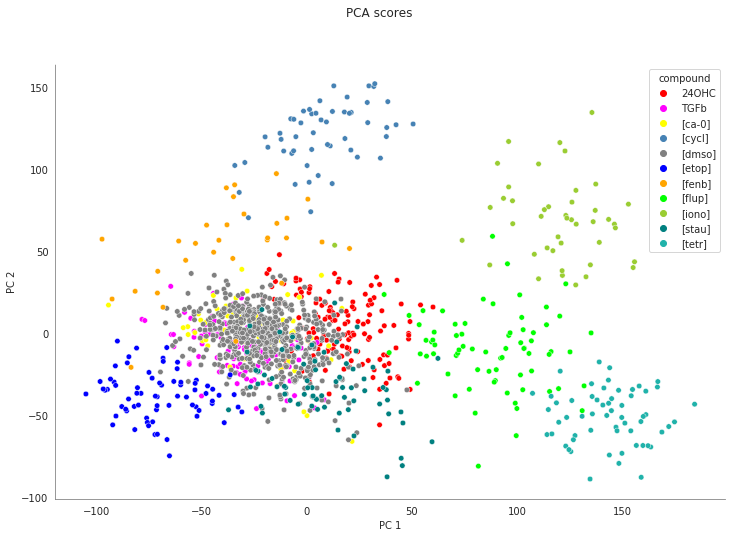

In [53]:
fig = plt.figure(figsize = (12,8))

dfSelectedCompConc = dfZscores.loc[dfZscores['comp_conc'].isin(SelectedCompConc)]
dfSelectedCompConc.reset_index(inplace=True, drop=True)
 
x = dfSelectedCompConc.loc[:, varying_in_DMSO].values
pca = PCA(n_components=50)
#x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
principalDf = principalDf.merge(dfSelectedCompConc[['compound', 'plate', 'comp_conc', 'well_id', 'site', 'concentration']], left_index = True, right_index = True)
principalDf.sort_values(by = [ 'compound', 'concentration'], inplace = True)
principalDf.reset_index(drop=True, inplace = True)  

nr_colors = len(set(principalDf.compound))
colors = colors[:nr_colors]

ax = fig.add_subplot(111) 
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='compound', data=principalDf, palette=colors,  s=30, alpha = 1,  marker = 'o');

ax.set_facecolor('w')

fig.suptitle('PCA scores'.format(), fontsize = 12)
fig.savefig('{}/PCA_{}_some_compounds.{}'.format(OutputDir, project, figformat),  dpi=dpi, bbox_inches='tight')
fig.savefig('{}/PCA_{}_some_compounds.{}'.format(OutputDir,  project, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for n_neighbors in range(5, 11, 5):      
            reducer = umap.UMAP(n_neighbors = n_neighbors)
            embedding = reducer.fit_transform(principalDf.iloc[:,:20] )
            umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
            umap_resultDf = pd.concat([umap_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            umap_resultDf.sort_values(by = ['compound',  'concentration'], inplace = True)
            umap_resultDf.to_csv('{}/umap.csv'.format(OutputDir), sep=';')
           
            nr_colors = len(set(umap_resultDf.compound))
            colors = colors[:nr_colors]
            
            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('umap 1', fontsize = 12)
            ax.set_ylabel('umap 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')

            ax =sns.scatterplot(x='umap 1', y='umap 2',  
                          hue='compound', data=umap_resultDf, palette=colors,  s=10, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

                                       
            """for target, color in zip(targets,colors):
                            indicesToKeep = umap_resultDf['compound'] == target
                            ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , edgecolors= None
                                       , alpha = 0.3
                                       , marker ='o'
                                       , s = 20
                                       )
            fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)"""

            fig.suptitle('umap, n_neigh={}.png'.format(n_neighbors), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  
            fig.savefig('{}/Umap_{}__some_compounds_nneighb_{}.{}'.format(OutputDir,  project, n_neighbors, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()

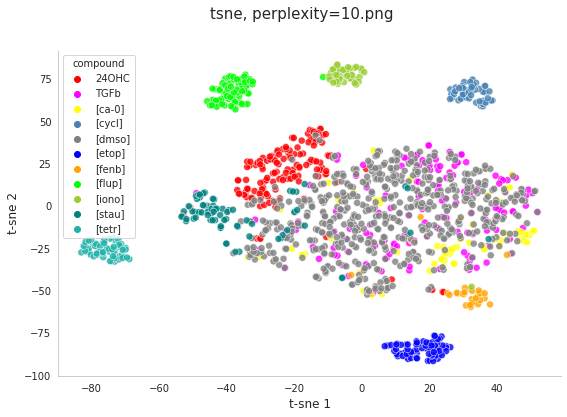

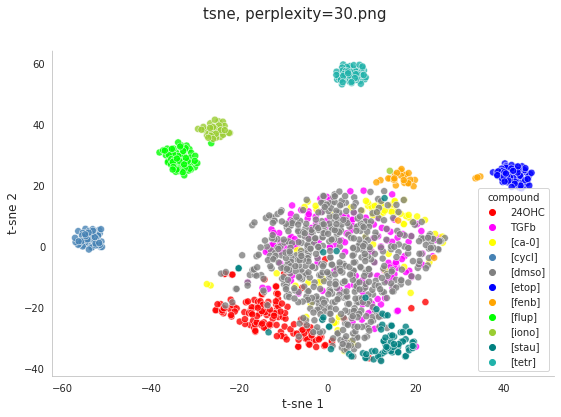

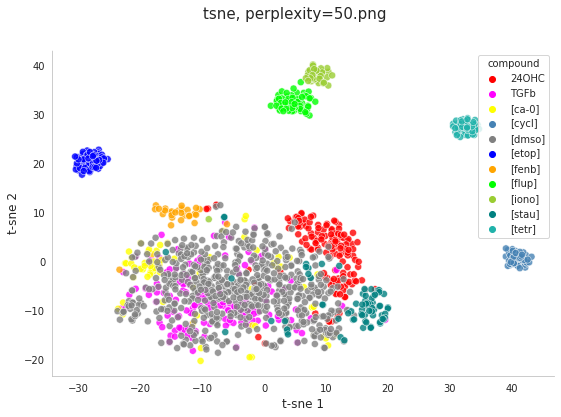

In [55]:
for perpl in range(10, 51, 20):
            x = principalDf.iloc[:, :50].values
            X_embedded = TSNE(n_components=2, perplexity=perpl).fit_transform(x)
            tsne_result = pd.DataFrame(data = X_embedded, columns=["tsne 1", "tsne 2"])
            tsne_resultDf = pd.concat([tsne_result, principalDf[['compound', 'plate', 'concentration', 'well_id', 'site', 'comp_conc']]], axis = 1)
            tsne_resultDf.sort_values(by = ['compound', 'concentration'], inplace = True)
            tsne_resultDf.to_csv('{}/tsne.csv'.format(OutputDir), sep=';')
            
            nr_colors = len(set(tsne_resultDf.compound))
            colors = colors[:nr_colors]

            fig = plt.figure(figsize = (9,6))

            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('t-sne 1', fontsize = 12)
            ax.set_ylabel('t-sne 2', fontsize = 12)
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')

            ax =sns.scatterplot(x='tsne 1', y='tsne 2',  
                          hue='compound', data=tsne_resultDf, palette=colors,  s=50, alpha = 0.8,  marker = 'o');
        
        

            ax.set_facecolor('w')

            fig.suptitle('tsne, perplexity={}.png'.format(perpl), fontsize = 15)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('silver')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('silver')
            ax.spines['right'].set_color('w')  

            fig.savefig('{}/Tsne_{}__some_compounds_perpl_{}.{}'.format(OutputDir,  project, perpl, figformat),  dpi=dpi, bbox_inches='tight')
            plt.show()